<div style="text-align:center">
    <h1>
        SARSA
    </h1>
</div>

<br><br>

<div style="text-align:center">
    In this notebook we are going to implement a method that learns from experience and uses bootstrapping.
    It is known as SARSA because of the elements involved in the update rule:
</div>

\begin{equation}
\text{State}_t, \text{Action}_t, \text{Reward}_t, \text{State}_{t+1}, \text{Action}_{t+1}
\end{equation}

<br>

<div style="text-align:center">
    This method follows an on-policy strategy, in which the same policy that is optimized is responsible for scanning the environment.
</div>


<br>



<br><br>
<div style="text-align:center">
    <b>This notebook belongs to section 5 of the course "Reinforcement Learning: beginner to master".</b>
    <br><br>
    <a href="https://www.udemy.com">Reinforcement Learning: beginner to master</a> (English)
    <br>
    <a href="https://www.udemy.com">Reinforcement Learning: de principiante a maestro</a> (Spanish)
</div>

<br>

<table style="width:35%">
  <tr style="background-color: transparent">
    <td style="width: 45%">
        <a target="_parent" href="https://www.evlabs.io" style="float: center">
            <img src="img/evlabs-square.png" width="75"/>
        </a> 
    </td>
    <td valign="bottom">
        <a target="_parent" href="https://www.youtube.com/channel/UCksRNSzWuMV5IfdrPlglqqw">
            <img src="img/YouTube.png" width="35"/>
        </a> 
    </td>
    <td>
        <a target="_parent" href="https://www.linkedin.com/company/evlabs">
            <img src="img/LinkedIn.png" width="35"/>
        </a> 
    </td>
    <td>
        <a target="_parent" href="https://twitter.com/evelabs">
            <img src="img/Twitter.png" width="35"/>
        </a> 
    </td>
    <td>
        <a target="_parent" href="https://github.com/escape-velocity-labs/">
            <img src="img/GitHub.png" width="35"/>
        </a> 
    </td>

  </tr>
  <tr style="background-color: transparent">
    <th style="text-align: center; width: 70%">Escape Velocity Labs</th>
  </tr>

</table>

<br>

## Import the necessary software libraries:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from envs import Maze
from utils import plot_policy, plot_action_values, test_agent

## Create the environment, value table and policy

#### Create the environment

#### Create the $Q(s, a)$ table

#### Create the policy $\pi(s)$

#### Plot the value table $Q(s,a)$

In [ ]:
plot_action_values(action_values)

#### Plot the policy

In [ ]:
plot_policy(action_values, env.render(mode='rgb_array'))

## Implement the algorithm

</br>

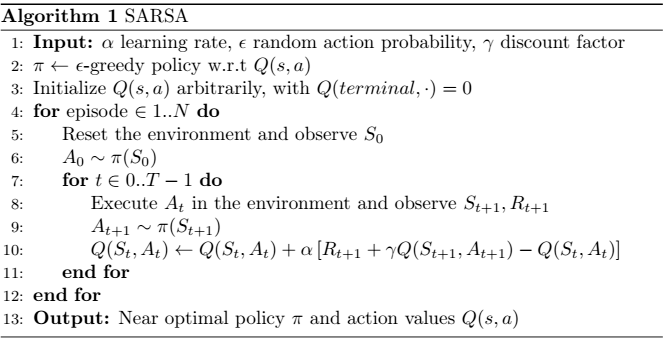

<div style="text-align:center">
    Adapted from Barto & Sutton: "Reinforcement Learning: An Introduction".
</div>

## Show results

#### Show resulting value table $Q(s,a)$

In [ ]:
plot_action_values(action_values)

#### Show resulting policy $\pi(\cdot|s)$

In [ ]:
plot_policy(action_values, env.render(mode='rgb_array'))

#### Test the resulting agent

In [ ]:
test_agent(env, policy)

## Resources

[[1] Reinforcement Learning: An Introduction. Ch. 6: Temporal difference learning](https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf)